## 2. Linear Regression

### 2.1 국가별 데이터 전처리

In [1]:
# 지역별 와인 분류
wine_US = pd.read_csv("wine_US.csv")
wine_france = pd.read_csv("wine_france.csv")
wine_italy = pd.read_csv("wine_italy.csv")

In [2]:
# 기온/강수량별 데이터 추가

wine_countries = [wine_US, wine_france, wine_italy]

for wine_country in wine_countries :  
    wine_tas = wine_country[['tas_Apr', 'tas_Aug', 'tas_Dec', 'tas_Feb', 'tas_Jan',
       'tas_Jul', 'tas_Jun', 'tas_Mar', 'tas_May', 'tas_Nov', 'tas_Oct',
       'tas_Sep']]
    wine_pr = wine_country[['pr_Apr', 'pr_Aug', 'pr_Dec', 'pr_Feb', 'pr_Jan', 'pr_Jul',
       'pr_Jun', 'pr_Mar', 'pr_May', 'pr_Nov', 'pr_Oct', 'pr_Sep']]

    wine_country["max_tas"] = wine_tas.max(axis=1, skipna= False)
    wine_country["min_tas"] = wine_tas.min(axis=1, skipna= False)
    wine_country["mean_tas"] = wine_tas.mean(axis=1, skipna= False)
    wine_country["var_tas"] = wine_tas.mad(axis=1, skipna= False)
    wine_country["max_pr"] = wine_pr.max(axis=1, skipna= False)
    wine_country["min_pr"] = wine_pr.min(axis=1, skipna= False)
    wine_country["mean_pr"] = wine_pr.mean(axis=1, skipna= False)
    wine_country["var_pr"] = wine_pr.mad(axis=1, skipna= False)

    wine_country["winterRain"] = (wine_country.pr_Jan + wine_country.pr_Feb + wine_country.pr_Mar)/3
    wine_country["seasonTemp"] = (wine_country.tas_May + wine_country.tas_Jun + wine_country.tas_Jul)/3
    wine_country["harvRain"] = (wine_country.pr_Jul + wine_country.pr_Aug)/2


In [3]:
# 다중공선성 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(wine_country):
    X = wine_country[['max_tas','min_tas', 'mean_tas', 'var_tas', 'max_pr', 'min_pr', 'mean_pr','var_pr',\
                      'winterRain', 'seasonTemp', 'harvRain']]
    vif = pd.DataFrame()
    vif["VifFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    result =  vif.sort_values(by="VifFactor", ascending=False)
    return result


### 2.1 wine of US 

In [4]:
wine_US.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53351 entries, 0 to 53350
Data columns (total 49 columns):
country        53351 non-null object
points         53351 non-null int64
price          53351 non-null int64
province       53351 non-null object
region_1       53116 non-null object
taster_name    36957 non-null object
variety        53351 non-null object
winery         53351 non-null object
year           53351 non-null int64
rank           53351 non-null float64
log_price      53351 non-null float64
cp             53351 non-null object
latitude       53351 non-null float64
longitude      53351 non-null float64
tas_Apr        53351 non-null float64
tas_Aug        53351 non-null float64
tas_Dec        53351 non-null float64
tas_Feb        53351 non-null float64
tas_Jan        53351 non-null float64
tas_Jul        53351 non-null float64
tas_Jun        53351 non-null float64
tas_Mar        53351 non-null float64
tas_May        53351 non-null float64
tas_Nov        53351 non-null 

In [5]:
wine_US["taster_name"] = wine_US.taster_name.fillna("etc")

wine_rank = wine_US.groupby("variety").size().rank(ascending=0)
variety_rank = pd.DataFrame(wine_rank, columns=["vrank"])
wine_US = pd.merge(wine_US, variety_rank, on=["variety"], how="outer")

In [6]:
vif(wine_US)

,VifFactor,features
9,1468.695425,seasonTemp
0,1218.142303,max_tas
2,757.033349,mean_tas
3,455.140718,var_tas
7,109.478863,var_pr
6,102.221388,mean_pr
4,84.202123,max_pr
10,22.969561,harvRain
8,19.907938,winterRain
5,12.222123,min_pr


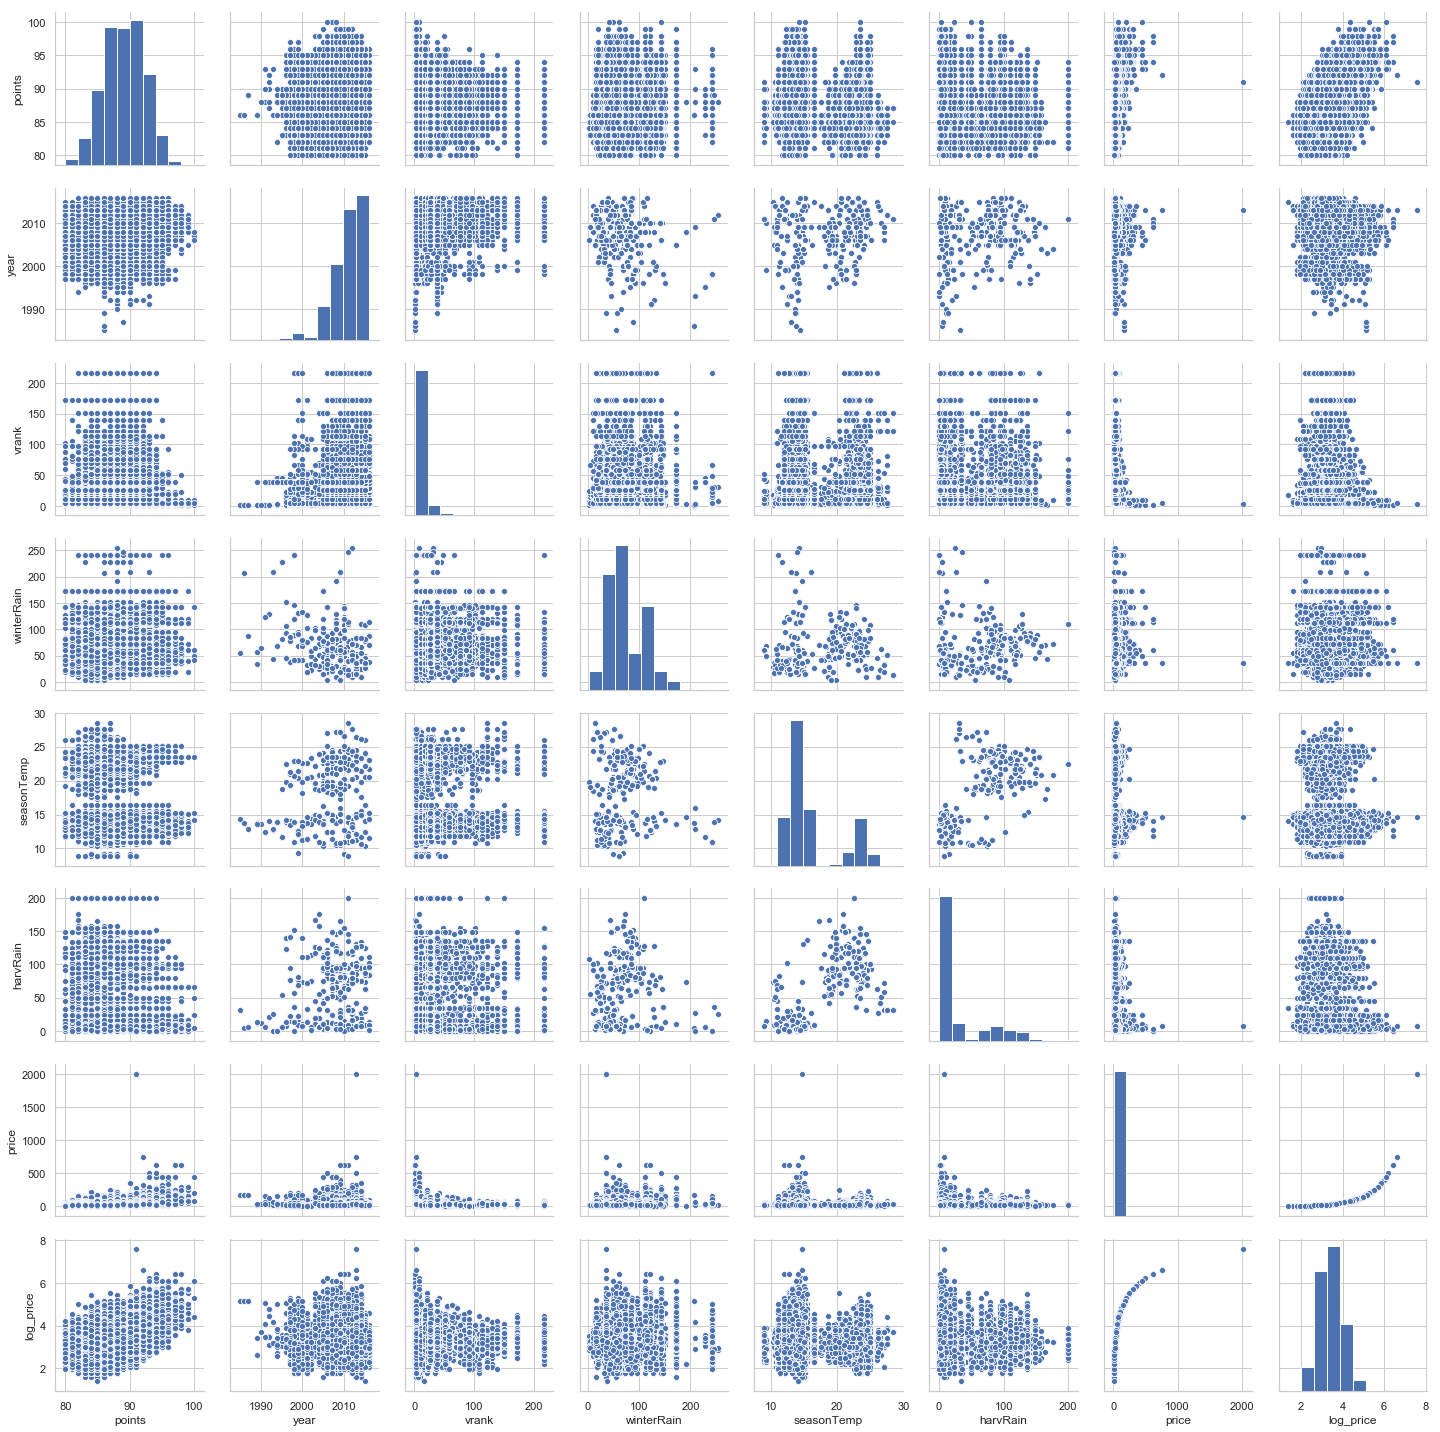

In [7]:
# pairplot 확인
wine_US_1 = wine_US[['points', 'year', 'vrank', 'winterRain', 'seasonTemp', 'harvRain', 'price', 'log_price']]
sns.pairplot(wine_US_1)


In [8]:
wine_US[wine_US['price']>1000]

,country,points,price,province,region_1,taster_name,variety,winery,year,rank,...,mean_tas,var_tas,max_pr,min_pr,mean_pr,var_pr,winterRain,seasonTemp,harvRain,vrank
25916,US,91,2013,California,Arroyo Seco,Matt Kettmann,Chardonnay,Blair,2013,2.0,...,7.958333,5.618056,55.400002,3.2,18.583333,14.594444,35.499999,14.6,7.25,3.0


In [9]:
# price 아웃라이어 제거
wine_US = wine_US[wine_US['price']<1000]

# seasonTemp 
wine_US["seasonTemp"] = wine_US["seasonTemp"].apply(lambda x : 0 if x < 18 else 1)

In [10]:
# 기존데이터(날씨 제외) OLS (R^2=0.312)
model_us1= sm.OLS.from_formula("log_price ~ scale(vrank) + scale(year) + scale(points)", wine_US)
result_us1= model_us1.fit()
print(result_us1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8068.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:23   Log-Likelihood:                -35916.
No. Observations:               53350   AIC:                         7.184e+04
Df Residuals:                   53346   BIC:                         7.187e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        20.2014      1.187     17.024

In [11]:
# 날씨데이터(기존 컬럼 제외) OLS (R^2=0.033)
model_us2 = sm.OLS.from_formula("log_price ~ scale(winterRain) + scale(mean_tas) \
+ scale(max_tas) + scale(np.log(harvRain +1 )**2) + seasonTemp", wine_US)
result_us2 = model_us2.fit()
print(result_us2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     360.0
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:24   Log-Likelihood:                -45011.
No. Observations:               53350   AIC:                         9.003e+04
Df Residuals:                   53344   BIC:                         9.009e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [12]:
# model1+model2합친 OLS (최종 모델)(R^2=0.327)
model_us = sm.OLS.from_formula("log_price ~ scale(vrank) + scale(year) + scale(points)\
+ scale(max_tas) + scale(winterRain) +scale(np.log(harvRain + 1) ** 2)+ scale(seasonTemp)", wine_US)
result_us = model_us.fit()
print(result_us.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     3697.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:27   Log-Likelihood:                -35344.
No. Observations:               53350   AIC:                         7.070e+04
Df Residuals:                   53342   BIC:                         7.078e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [13]:
formula_us = "log_price ~ scale(vrank) + scale(year) + scale(points)\
+ scale(max_tas) + scale(winterRain) +scale(np.log(harvRain + 1) ** 2)+ scale(seasonTemp)"

In [14]:
print("TSS = ", result_us.uncentered_tss)
print("ESS = ", result_us.mse_model)
print("RSS = ", result_us.ssr)
print("ESS + RSS = ", result_us.mse_model + result_us.ssr)
print("R squared = ", result_us.rsquared)

TSS =  646450.0376216738
ESS =  814.5660866735265
RSS =  11751.732912682193
ESS + RSS =  12566.29899935572
R squared =  0.32669084895963163


In [15]:
# train_test_split
from sklearn.model_selection import train_test_split

df_train_us, df_test_us = train_test_split(wine_US, test_size=0.4, random_state=1)
df_train_us.shape, df_test_us.shape

((32010, 50), (21340, 50))

In [16]:
# KFold 검증
df_train_us = sm.add_constant(df_train_us)
df_test_us = sm.add_constant(df_test_us)

temp_train_us = df_train_us.copy()
temp_test_us = df_test_us.copy()

temp_train_us = temp_train_us[["log_price", "vrank", "year", "points","max_tas", "winterRain", "harvRain", "seasonTemp"]]

from sklearn.model_selection import KFold
from patsy import *

split_number = 5
cv = KFold(split_number, shuffle=True, random_state=3)
train_R2 = []
test_R2 = []

for i, (idx_train, idx_test) in enumerate(cv.split(temp_train_us)):
    df_train_us = temp_train_us.iloc[idx_train]
    df_test_us = temp_train_us.iloc[idx_test]

    model = sm.OLS.from_formula(formula_us, data=df_train_us)
    result = model.fit()
        
    pred = result.predict(df_test_us)
    rss = ((df_test_us.log_price - pred) ** 2).sum()
    ess = ((pred - pred.mean()) ** 2).sum()
    tss = ((df_test_us.log_price - df_test_us.log_price.mean())** 2).sum()
    rsquared = ess / tss
    train_R2.append(result.rsquared)
    test_R2.append(rsquared)
    
R2_US = pd.DataFrame([train_R2, test_R2], index = ["US_train_R2", "US_test_R2"])
R2_US


,0,1,2,3,4
US_train_R2,0.330321,0.328659,0.326982,0.329412,0.327888
US_test_R2,0.105698,0.143927,0.120831,0.114532,0.112623


### 2.2 wine of France

In [17]:
wine_france.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16387 entries, 0 to 16386
Data columns (total 49 columns):
country        16387 non-null object
points         16387 non-null int64
price          16387 non-null int64
province       16387 non-null object
region_1       16319 non-null object
taster_name    16167 non-null object
variety        16387 non-null object
winery         16387 non-null object
year           16387 non-null int64
rank           16387 non-null float64
log_price      16387 non-null float64
cp             16387 non-null object
latitude       16387 non-null float64
longitude      16387 non-null float64
tas_Apr        16387 non-null float64
tas_Aug        16387 non-null float64
tas_Dec        16387 non-null float64
tas_Feb        16387 non-null float64
tas_Jan        16387 non-null float64
tas_Jul        16387 non-null float64
tas_Jun        16387 non-null float64
tas_Mar        16387 non-null float64
tas_May        16387 non-null float64
tas_Nov        16387 non-null 

In [18]:
wine_france["taster_name"] = wine_france.taster_name.fillna("etc")

wine_rank = wine_france.groupby("variety").size().rank(ascending=0)
variety_rank = pd.DataFrame(wine_rank, columns=["vrank"])
wine_france = pd.merge(wine_france, variety_rank, on=["variety"], how="outer")

In [19]:
vif(wine_france)

,VifFactor,features
9,2109.849059,seasonTemp
2,1172.942940,mean_tas
0,1051.609313,max_tas
3,553.123154,var_tas
6,161.409778,mean_pr
4,96.686587,max_pr
7,54.608907,var_pr
1,35.569707,min_tas
8,24.656378,winterRain
5,11.614029,min_pr


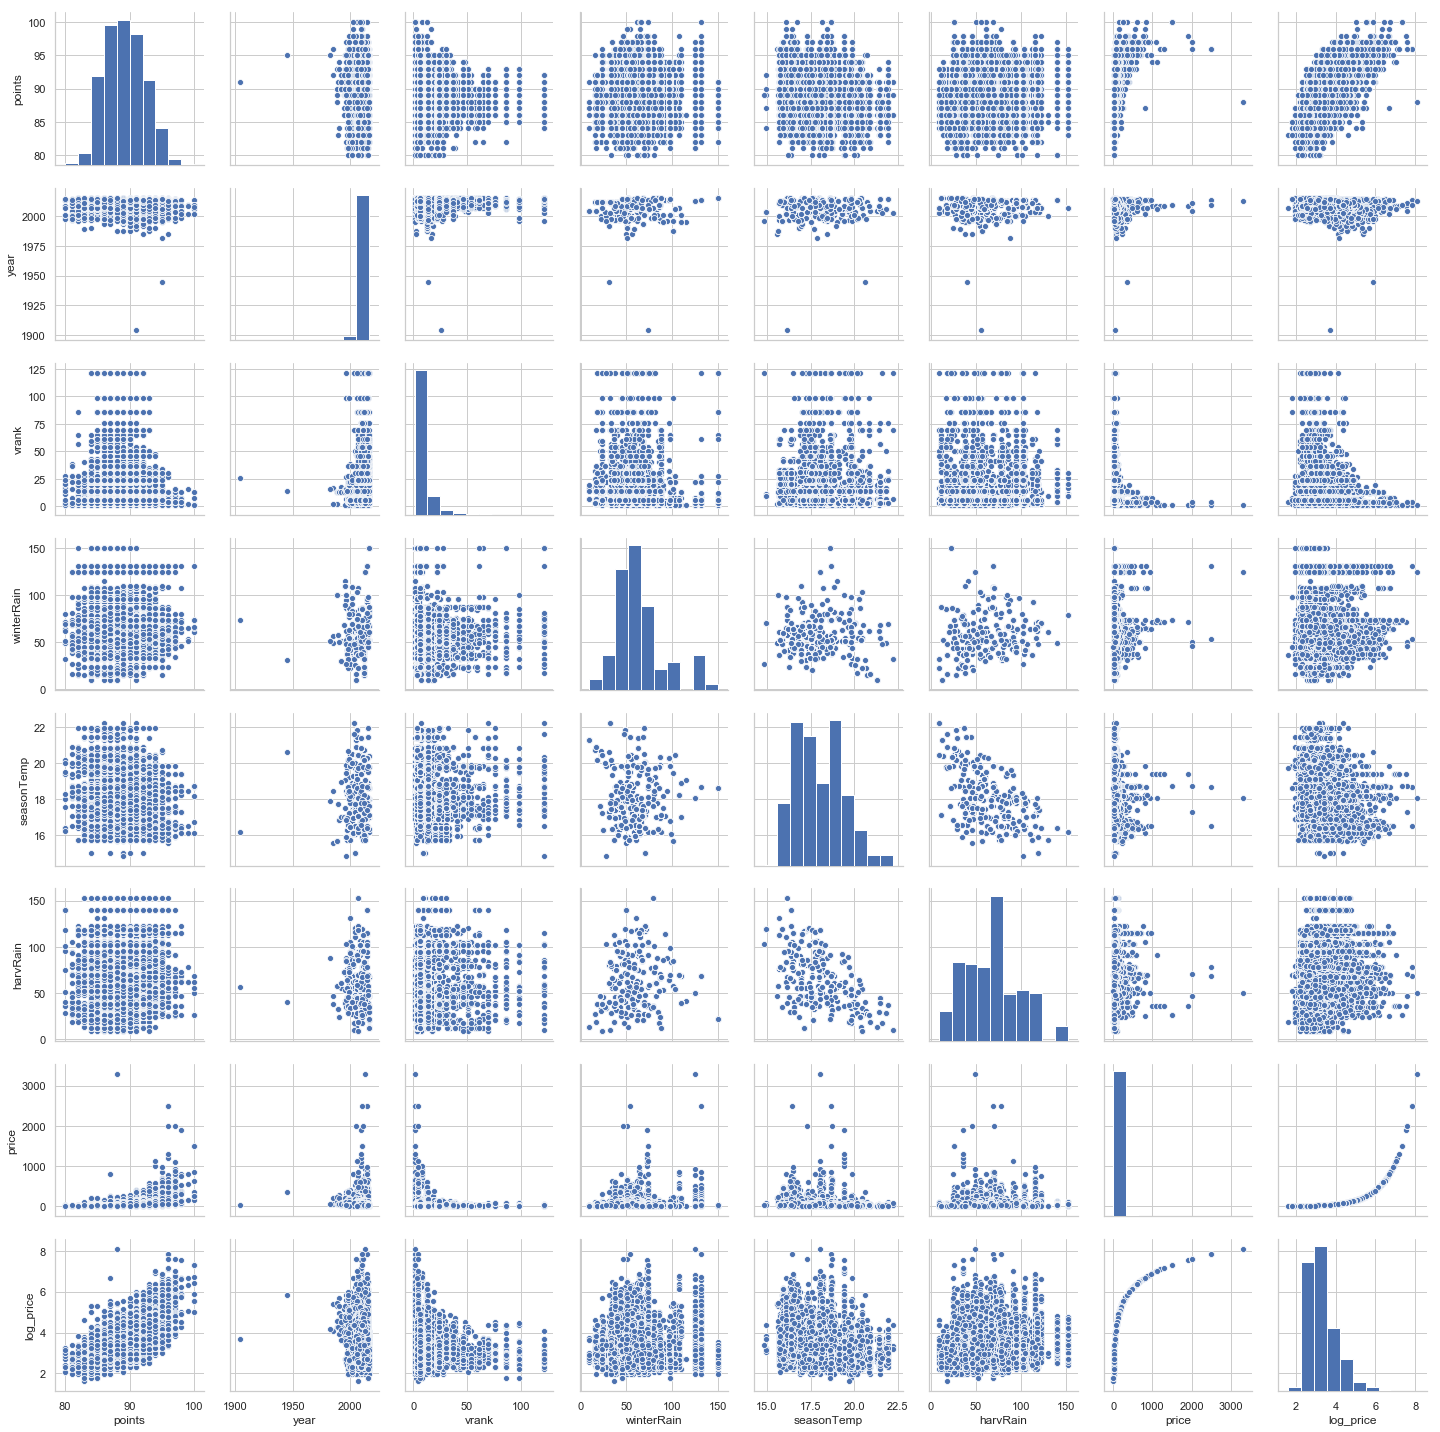

In [20]:
wine_france_1 = wine_france[['points', 'year', 'vrank', 'winterRain', 'seasonTemp', 'harvRain', 'price', 'log_price']]
sns.pairplot(wine_france_1)

In [21]:
wine_france[wine_france["year"]<1950]

,country,points,price,province,region_1,taster_name,variety,winery,year,rank,...,mean_tas,var_tas,max_pr,min_pr,mean_pr,var_pr,winterRain,seasonTemp,harvRain,vrank
15019,France,95,350,Languedoc-Roussillon,Rivesaltes,Lauren Buzzeo,Red Blend,Gérard Bertrand,1945,4.0,...,13.600000,5.916667,116.099998,6.5,49.475000,30.091667,30.800000,20.633334,40.049999,14.0
15361,France,91,40,Alsace,Crémant d'Alsace,Anne Krebiehl MW,Sparkling Blend,Arthur Metz,1904,26.0,...,8.583333,5.916667,128.300003,29.5,62.441668,25.065279,74.100001,16.133334,55.950003,26.0


In [22]:
# year 아웃라이어 삭제
wine_france = wine_france[wine_france["year"]>1900]

In [23]:
# 기존데이터(날씨 제외) OLS (R^2=0.503)
model_fr1= sm.OLS.from_formula("log_price ~ scale(vrank) + C(taster_name) + scale(points)", wine_france)
result_fr1= model_fr1.fit()
print(result_fr1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     2074.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:48   Log-Likelihood:                -12545.
No. Observations:               16387   AIC:                         2.511e+04
Df Residuals:                   16378   BIC:                         2.518e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [24]:
# 날씨데이터(기존 컬럼 제외) OLS (R^2=0.131)
model_fr2= sm.OLS.from_formula("log_price ~ scale(winterRain) + scale(harvRain)\
+ scale(max_tas) + scale(np.log(max_tas)) + scale(min_tas)\
+ scale(np.log(min_pr +3)) + scale(np.log(harvRain)) ", wine_france)
result_fr2= model_fr2.fit()
print(result_fr2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     351.7
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:49   Log-Likelihood:                -17131.
No. Observations:               16387   AIC:                         3.428e+04
Df Residuals:                   16379   BIC:                         3.434e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [25]:
# model1+model2합친 OLS (최종 모델)(R^2=0.543)
model_fr= sm.OLS.from_formula("log_price ~ scale(vrank) + C(taster_name)\
+ scale(points) +scale(winterRain) + scale(harvRain)\
+ scale(max_tas) + scale(np.log(max_tas))\
+ scale(np.log(min_pr +3)) + scale(np.log(harvRain))", wine_france)
result_fr= model_fr.fit()
print(result_fr.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1389.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:52:50   Log-Likelihood:                -11862.
No. Observations:               16387   AIC:                         2.375e+04
Df Residuals:                   16372   BIC:                         2.387e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [26]:
formula_fr_origin = "log_price ~ scale(vrank) + C(taster_name) + scale(points)"
formula_fr_meta = "log_price ~ scale(vrank) + C(taster_name) + scale(points) +scale(winterRain) + scale(harvRain)\
            + scale(max_tas) + scale(np.log(max_tas)) + scale(np.log(min_pr +3)) + scale(np.log(harvRain))"

In [27]:
print("TSS = ", result_fr.uncentered_tss)
print("ESS = ", result_fr.mse_model)
print("RSS = ", result_fr.ssr)
print("ESS + RSS = ", result_fr.mse_model + result_fr.ssr)
print("R squared = ", result_fr.rsquared)

TSS =  188749.38895938208
ESS =  346.337387976692
RSS =  4081.240468160028
ESS + RSS =  4427.57785613672
R squared =  0.5429723441282865


In [28]:
# train_test_split
from sklearn.model_selection import train_test_split

df_train_fr, df_test_fr = train_test_split(wine_france, test_size=0.4, random_state=4)
df_train_fr.shape, df_test_fr.shape

((9832, 50), (6555, 50))

In [29]:
df_train_fr = sm.add_constant(df_train_fr)
df_test_fr = sm.add_constant(df_test_fr)

temp_train_fr = df_train_fr.copy()
temp_test_fr = df_test_fr.copy()

temp_train_fr = temp_train_fr[["log_price", "vrank", "taster_name",\
"points","winterRain", "harvRain", "max_tas", "min_pr"]]



from sklearn.model_selection import KFold
from patsy import *

split_number = 5
cv = KFold(split_number, shuffle=True, random_state=3)
train_R2 = []
test_R2 = []

for i, (idx_train, idx_test) in enumerate(cv.split(temp_train_fr)):
    df_train_fr = temp_train_fr.iloc[idx_train]
    df_test_fr = temp_train_fr.iloc[idx_test]

    model = sm.OLS.from_formula(formula_fr_origin, data=df_train_fr)
    result = model.fit()
        
    pred = result.predict(df_test_fr)
    rss = ((df_test_fr.log_price - pred) ** 2).sum()
    ess = ((pred - pred.mean()) ** 2).sum()
    tss = ((df_test_fr.log_price - df_test_fr.log_price.mean())** 2).sum()
    rsquared = ess / tss
    train_R2.append(result.rsquared)
    test_R2.append(rsquared)

    
dic = {
    "R_squared" : train_R2 + test_R2,
    "split" : ["train"]*5 + ["test"]*5,
    "data_type" : "origin",
    "country" : "france",
}

df_france_origin = pd.DataFrame(dic)


R2_france_origin = pd.DataFrame([train_R2, test_R2], index = ["Fr_org_train_R2", "Fr_org_test_R2"])
R2_france_origin

,0,1,2,3,4
Fr_org_train_R2,0.496006,0.505476,0.502607,0.509985,0.507477
Fr_org_test_R2,0.523466,0.473291,0.516773,0.499262,0.511045


In [30]:
df_train_fr = sm.add_constant(df_train_fr)
df_test_fr = sm.add_constant(df_test_fr)

temp_train_fr = df_train_fr.copy()
temp_test_fr = df_test_fr.copy()

temp_train_fr = temp_train_fr[["log_price", "vrank", "taster_name",\
"points","winterRain", "harvRain", "max_tas", "min_pr"]]



from sklearn.model_selection import KFold
from patsy import *

split_number = 5
cv = KFold(split_number, shuffle=True, random_state=3)
train_R2 = []
test_R2 = []

for i, (idx_train, idx_test) in enumerate(cv.split(temp_train_fr)):
    df_train_fr = temp_train_fr.iloc[idx_train]
    df_test_fr = temp_train_fr.iloc[idx_test]

    model = sm.OLS.from_formula(formula_fr_meta, data=df_train_fr)
    result = model.fit()
        
    pred = result.predict(df_test_fr)
    rss = ((df_test_fr.log_price - pred) ** 2).sum()
    ess = ((pred - pred.mean()) ** 2).sum()
    tss = ((df_test_fr.log_price - df_test_fr.log_price.mean())** 2).sum()
    rsquared = ess / tss
    train_R2.append(result.rsquared)
    test_R2.append(rsquared)
    

dic = {
    "R_squared" : train_R2 + test_R2,
    "split" : ["train"]*5 + ["test"]*5,
    "data_type" : "meta",
    "country" : "france",
}

df_france_meta = pd.DataFrame(dic)

    
    
R2_france_meta = pd.DataFrame([train_R2, test_R2], index = ["Fr_mt_train_R2", "Fr_mt_test_R2"])
R2_france_meta

,0,1,2,3,4
Fr_mt_train_R2,0.543091,0.546900,0.544250,0.549767,0.544200
Fr_mt_test_R2,0.538772,0.552485,0.536997,0.545854,0.559198


### 2.3 wine of Italy

In [31]:
wine_italy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16069 entries, 0 to 16068
Data columns (total 49 columns):
country        16069 non-null object
points         16069 non-null int64
price          16069 non-null int64
province       16069 non-null object
region_1       16069 non-null object
taster_name    9794 non-null object
variety        16069 non-null object
winery         16069 non-null object
year           16069 non-null int64
rank           16069 non-null float64
log_price      16069 non-null float64
cp             16069 non-null object
latitude       16069 non-null float64
longitude      16069 non-null float64
tas_Apr        16069 non-null float64
tas_Aug        16069 non-null float64
tas_Dec        16069 non-null float64
tas_Feb        16069 non-null float64
tas_Jan        16069 non-null float64
tas_Jul        16069 non-null float64
tas_Jun        16069 non-null float64
tas_Mar        16069 non-null float64
tas_May        16069 non-null float64
tas_Nov        16069 non-null f

In [32]:
wine_italy["taster_name"] = wine_italy.taster_name.fillna("etc")

wine_rank = wine_italy.groupby("variety").size().rank(ascending=0)
variety_rank = pd.DataFrame(wine_rank, columns=["vrank"])
wine_italy = pd.merge(wine_italy, variety_rank, on=["variety"], how="outer")

In [33]:
vif(wine_italy)

,VifFactor,features
9,2191.042594,seasonTemp
2,1314.698722,mean_tas
0,1306.646780,max_tas
3,935.826873,var_tas
6,147.276935,mean_pr
4,76.223505,max_pr
7,71.554083,var_pr
1,67.030151,min_tas
8,18.665116,winterRain
10,12.987875,harvRain


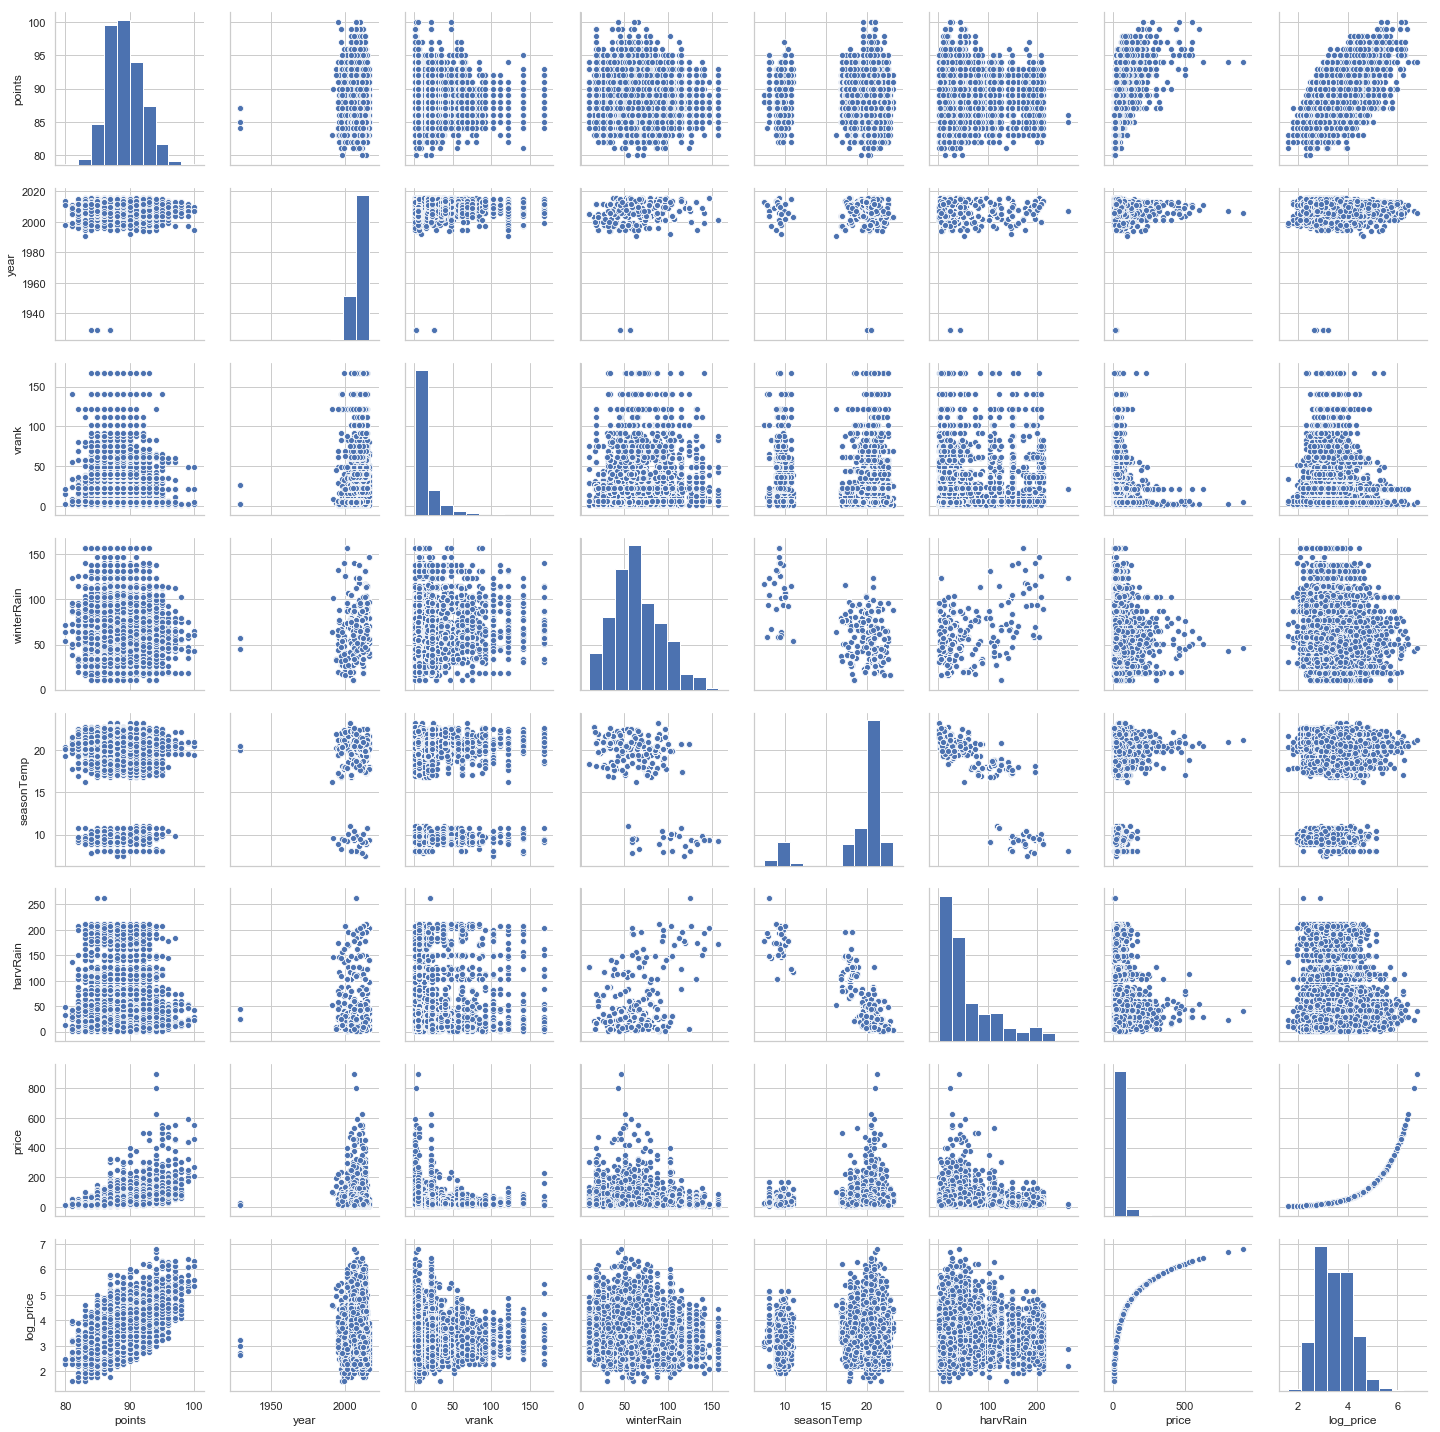

In [34]:
wine_italy_1 = wine_italy[['points', 'year', 'vrank', 'winterRain', 'seasonTemp', 'harvRain', 'price', 'log_price']]
sns.pairplot(wine_italy_1)

In [35]:
wine_italy[wine_italy["year"]<1950]

,country,points,price,province,region_1,taster_name,variety,winery,year,rank,...,mean_tas,var_tas,max_pr,min_pr,mean_pr,var_pr,winterRain,seasonTemp,harvRain,vrank
5813,Italy,87,25,Central Italy,Sangiovese di Romagna Superiore,etc,Sangiovese,Poderi dal Nespoli 1929,1929,13.0,...,12.783334,6.750,178.100006,2.0,61.141668,31.991667,45.366668,20.000001,44.799999,3.0
5955,Italy,87,20,Tuscany,Chianti Colli Senesi,Kerin O’Keefe,Sangiovese,Guidi 1929,1929,13.0,...,13.175000,6.675,136.600006,6.6,52.108335,30.293057,56.700001,20.400000,24.700000,3.0
6161,Italy,84,15,Central Italy,Sangiovese di Romagna Superiore,etc,Sangiovese,Poderi dal Nespoli 1929,1929,13.0,...,12.783334,6.750,178.100006,2.0,61.141668,31.991667,45.366668,20.000001,44.799999,3.0
6384,Italy,85,20,Tuscany,Chianti,Kerin O’Keefe,Sangiovese,Guidi 1929,1929,13.0,...,13.175000,6.675,136.600006,6.6,52.108335,30.293057,56.700001,20.400000,24.700000,3.0
6866,Italy,85,25,Tuscany,Vernaccia di San Gimignano,Kerin O’Keefe,Vernaccia,Guidi 1929,1929,74.0,...,13.175000,6.675,136.600006,6.6,52.108335,30.293057,56.700001,20.400000,24.700000,26.0
6951,Italy,87,14,Tuscany,Vernaccia di San Gimignano,Kerin O’Keefe,Vernaccia,Guidi 1929,1929,74.0,...,13.175000,6.675,136.600006,6.6,52.108335,30.293057,56.700001,20.400000,24.700000,26.0


In [36]:
# year 아웃라이어 제거
wine_italy = wine_italy[wine_italy["year"]>1950]

# seasonTemp 카테고리화
wine_italy["seasonTemp"] = wine_italy["seasonTemp"].apply(lambda x : 0 if x<15 else 1)

In [37]:
# 기존데이터(날씨 제외) OLS (R^2=0.454)
model_it1= sm.OLS.from_formula("log_price ~ scale(vrank) + scale(np.log(year)) + scale(points)\
", wine_italy)
result_it1= model_it1.fit()
print(result_it1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     4459.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:53:08   Log-Likelihood:                -11585.
No. Observations:               16063   AIC:                         2.318e+04
Df Residuals:                   16059   BIC:                         2.321e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             420.6526    

In [38]:
# 날씨데이터(기존 컬럼 제외) OLS (R^2=0.066)
model_it2 = sm.OLS.from_formula("log_price ~ scale(np.log(winterRain)**2) + scale(np.log(harvRain)) \
+ scale(max_tas) + scale(min_tas)+ seasonTemp", wine_italy)
result_it2 = model_it2.fit()
print(result_it2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     227.0
Date:                Sun, 07 Jul 2019   Prob (F-statistic):          6.00e-235
Time:                        05:53:08   Log-Likelihood:                -15904.
No. Observations:               16063   AIC:                         3.182e+04
Df Residuals:                   16057   BIC:                         3.187e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [39]:
# model1+model2합친 OLS (최종 모델)(R^2=0.473)
model_it= sm.OLS.from_formula("log_price ~ scale(vrank) + scale(np.log(year)) + scale(points)\
+ scale(np.log(winterRain)**2) + scale(np.log(harvRain)) + scale(max_tas) + scale(min_tas) + seasonTemp", wine_italy)
result_it= model_it.fit()
print(result_it.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     1799.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:53:09   Log-Likelihood:                -11312.
No. Observations:               16063   AIC:                         2.264e+04
Df Residuals:                   16054   BIC:                         2.271e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [40]:
formula_it_origin = "log_price ~ scale(vrank) + scale(np.log(year)) + scale(points)"
formula_it_meta = "log_price ~ scale(vrank) + scale(np.log(year)) + scale(points)\
+ scale(np.log(winterRain)**2) + scale(np.log(harvRain)) + scale(max_tas) + scale(min_tas) + seasonTemp"

In [41]:
print("TSS = ", result_it.uncentered_tss)
print("ESS = ", result_it.mse_model)
print("RSS = ", result_it.ssr)
print("ESS + RSS = ", result_it.mse_model + result.ssr)
print("R squared = ", result_it.rsquared)

TSS =  198569.89232196446
ESS =  431.0278186156926
RSS =  3846.143692855002
ESS + RSS =  2055.937198730717
R squared =  0.47272407699724095


In [42]:
# train_test_split
from sklearn.model_selection import train_test_split

df_train_it, df_test_it = train_test_split(wine_italy, test_size=0.4, random_state=1)
df_train_it.shape, df_test_it.shape

((9637, 50), (6426, 50))

In [43]:
df_train_it = sm.add_constant(df_train_it)
df_test_it = sm.add_constant(df_test_it)

temp_train_it = df_train_it.copy()
temp_test_it = df_test_it.copy()

temp_train_it = temp_train_it[["log_price", "vrank", "year", "points", "max_tas","min_tas", "winterRain", "harvRain", "seasonTemp"]]

from sklearn.model_selection import KFold
from patsy import *

split_number = 5
cv = KFold(split_number, shuffle=True, random_state=3)
train_R2 = []
test_R2 = []

for i, (idx_train, idx_test) in enumerate(cv.split(temp_train_it)):
    df_train_it = temp_train_it.iloc[idx_train]
    df_test_it = temp_train_it.iloc[idx_test]

    model = sm.OLS.from_formula(formula_it_origin, data=df_train_it)
    result = model.fit()
        
    pred = result.predict(df_test_it)
    rss = ((df_test_it.log_price - pred) ** 2).sum()
    ess = ((pred - pred.mean()) ** 2).sum()
    tss = ((df_test_it.log_price - df_test_it.log_price.mean())** 2).sum()
    rsquared = ess / tss
    train_R2.append(result.rsquared)
    test_R2.append(rsquared)


dic = {
    "R_squared" : train_R2 + test_R2,
    "split" : ["train"]*5 + ["test"]*5,
    "data_type" : "origin",
    "country" : "italy",
}

df_it_origin = pd.DataFrame(dic)
    
R2_italy_origin = pd.DataFrame([train_R2, test_R2], index = ["It_org_train_R2", "It_org_test_R2"])
R2_italy_origin

,0,1,2,3,4
It_org_train_R2,0.461686,0.460815,0.458798,0.454567,0.458310
It_org_test_R2,0.437624,0.451772,0.467832,0.436780,0.503914


In [44]:
df_train_it = sm.add_constant(df_train_it)
df_test_it = sm.add_constant(df_test_it)

temp_train_it = df_train_it.copy()
temp_test_it = df_test_it.copy()

temp_train_it = temp_train_it[["log_price", "vrank", "year", "points", "max_tas","min_tas", "winterRain", "harvRain", "seasonTemp"]]

from sklearn.model_selection import KFold
from patsy import *

split_number = 5
cv = KFold(split_number, shuffle=True, random_state=3)
train_R2 = []
test_R2 = []

for i, (idx_train, idx_test) in enumerate(cv.split(temp_train_it)):
    df_train_it = temp_train_it.iloc[idx_train]
    df_test_it = temp_train_it.iloc[idx_test]

    model = sm.OLS.from_formula(formula_it_meta, data=df_train_it)
    result = model.fit()
        
    pred = result.predict(df_test_it)
    rss = ((df_test_it.log_price - pred) ** 2).sum()
    ess = ((pred - pred.mean()) ** 2).sum()
    tss = ((df_test_it.log_price - df_test_it.log_price.mean())** 2).sum()
    rsquared = ess / tss
    train_R2.append(result.rsquared)
    test_R2.append(rsquared)
    
dic = {
    "R_squared" : train_R2 + test_R2,
    "split" : ["train"]*5 + ["test"]*5,
    "data_type" : "meta",
    "country" : "italy",
}

df_it_meta = pd.DataFrame(dic)

R2_italy_meta = pd.DataFrame([train_R2, test_R2], index = ["It_mt_train_R2", "It_mt_test_R2"])
R2_italy_meta


,0,1,2,3,4
It_mt_train_R2,0.471723,0.477740,0.48076,0.474008,0.468116
It_mt_test_R2,0.510905,0.477869,0.48460,0.466562,0.437304


In [45]:
df_fr = pd.concat([df_france_origin, df_france_meta])
df_it = pd.concat([df_it_origin, df_it_meta])
df_fr_it = pd.concat([df_france_origin, df_france_meta, df_it_origin, df_it_meta])

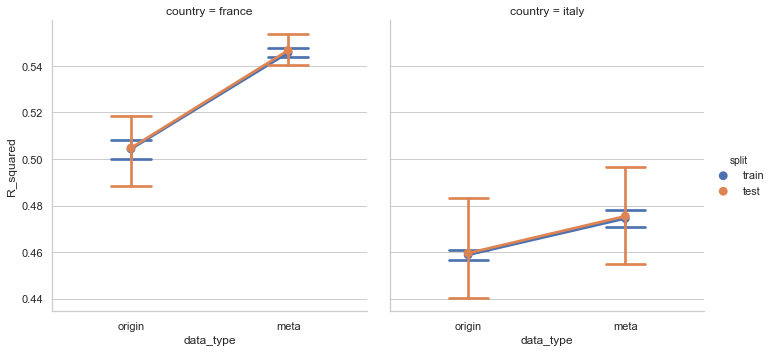

In [46]:
sns.catplot(x="data_type", y="R_squared", hue="split", col="country", col_wrap=2, kind="point", capsize=.25, data = df_fr_it)
plt.show()
